<a href="https://colab.research.google.com/github/wonmyeong/nlp_colab/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import os
import sys
if 'google.colab' in sys.modules:
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    if not os.path.isdir('data'):
        # 데이터를 다운받고 압축을 풉니다.
        !wget -q -O data.tar.gz https://bit.ly/data-tar-gz
        !tar -xzf data.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 48.2 MB/s eta 0:00:00


In [ ]:
!pip install -q tweepy==3.10

In [2]:
try:
    import konlpy
except:
    !pip install -q konlpy
    import konlpy

import pandas as pd
import numpy as np

konlpy.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 32.7 MB/s eta 0:00:00


'0.6.0'

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (44.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121920 files and direc

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')


In [5]:
review_pos_df = pd.read_csv("review_pos_data_df")
review_neg_df = pd.read_csv("review_neg_data_df")

In [6]:
review_pos_df.drop(columns=["Unnamed: 0"],inplace=True)
review_neg_df.drop(columns=["Unnamed: 0"],inplace=True)

In [7]:
review_neg_df['SentimentPolarity'] =0

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

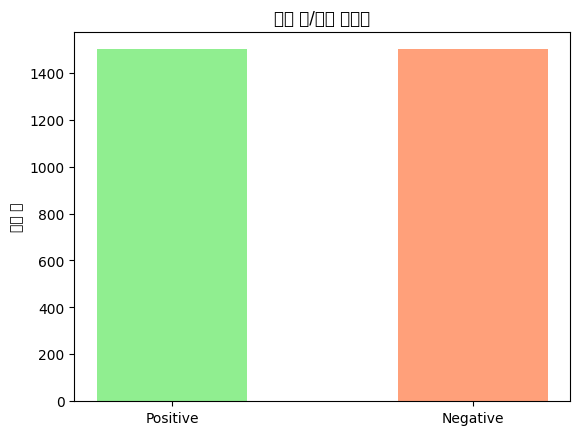

In [8]:
# Assuming review_pos_df and review_neg_df are two dataframes
# 모델에 학습시킬 데이터 비율 1:1
lengths = [len(review_pos_df), len(review_neg_df)]
labels = ['Positive', 'Negative']
colors = ['#90EE90', '#FFA07A']

fig, ax = plt.subplots()
ax.bar(labels, lengths, color=colors, width=0.5)
ax.set_ylabel("리뷰 수")
ax.set_title("리뷰 긍/부정 데이터")

plt.subplots_adjust(wspace=1)

plt.show()

In [9]:
concat_df = pd.concat([review_pos_df,review_neg_df],ignore_index=True)

In [10]:
concat_df.columns=['review','label']

In [11]:
concat_df.to_csv("concat_review_df")

In [12]:
concat_df.columns

Index(['review', 'label'], dtype='object')

In [13]:
text_test = concat_df['review'].values
y_test = concat_df['label'].values


In [14]:
from konlpy.tag import Okt

class PicklableOkt(Okt):
    def __init__(self, *args):
        self.args = args
        Okt.__init__(self, *args)

    def __getstate__(self):
        return {'args': self.args}

    def __setstate__(self, state):
        self.__init__(*state['args'])

    # 조사 제외, 구두점 제거
    def clean_text(self, text):
        tokens = self.pos(text)
        # 조사를 제외하고 구두점 제거
        tokens = [word for word, pos in tokens if pos != 'Josa']
        tokens = [word for word in tokens if word not in (' ', '', '.', ',', '!', '?','(', ')')]  # 필요한 경우 구두점 추가
        return ' '.join(tokens)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV #최적의 파라미터 값을 찾는 라이브러리

# 직렬화 가능한 PickableOkt 사용하여 파이프라인 생성
param_grid = {
    'tfidfvectorizer__min_df': [3, 7, 10],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logisticregression__C': [0.1, 1, 10]
}

pipe = make_pipeline(TfidfVectorizer(tokenizer=PicklableOkt().morphs), LogisticRegression())
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(tokenizer=<bound method Okt.morphs of <__main__.PicklableOkt object at 0x7e99a1e7f340>>)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 10],
                         'tfidfvectorizer__min_df': [3, 7, 10],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [19]:
final_olive_review = pd.read_csv("final_olive_review_data_df")

In [23]:
final_olive_review.drop(columns={"Unnamed: 0"},inplace=True)

In [25]:
final_olive_review.head()

,userId,rating,reviews
0,와바밤,1,사실 마스크 팩 한 달동 안 사용 것 아니라 한 달 리뷰 하기 얘 매하 긴한데 어쩃...
1,와바밤,1,배송비 가격 맞출 때 유용하게 매번 구매 있습니다 자극 없이 순해여
2,보부상출신,1,나이 먹으니까 피부 고민 점차 주름 미백 쪽 빠지는데데 일리 피부 결 톤 케어 하기...
3,파이지니,1,🌼 1일 1 팩 하기 좋은 가성 비 마스크 팩 🌼 메디 힐 마스크 팩 너무 유명하죠...
4,보부상출신,1,요즘 제 피부 상태 탄력 지금 저 세상 가있는데 복구 위해 콜라겐 마스크 팩 이용 ...


In [33]:
final_olive_review[final_olive_review['reviews'].isna() ==True]

,userId,rating,reviews
71,수지여사57,1,NaN


In [34]:
missing_values = final_olive_review['reviews'].isna().sum()

# If there are missing values, drop the corresponding rows
if missing_values > 0:
    final_olive_review.dropna(subset=['reviews'], inplace=True)

In [35]:
final_olive_review[final_olive_review['reviews'].isna() ==True]

,userId,rating,reviews


In [42]:
x_test = final_olive_review['reviews']
y_test = final_olive_review['rating']

In [43]:
# Create an empty list to store predicted classes
predicted_classes = []

# Iterate over each review in the DataFrame column
for review in final_olive_review['reviews']:
    # Make prediction using the best estimator found by GridSearchCV
    predicted_class = grid.predict([review])

    # Append the predicted class to the list
    predicted_classes.append(predicted_class[0])  # Access the predicted class (it's a numpy array) and append

# Add the predicted classes as a new column named 'prediction' to the DataFrame
final_olive_review['prediction'] = predicted_classes



            userId  rating                                            reviews  \
0              와바밤       1  사실 마스크 팩 한 달동 안 사용 것 아니라 한 달 리뷰 하기 얘 매하 긴한데 어쩃...   
1              와바밤       1              배송비 가격 맞출 때 유용하게 매번 구매 있습니다 자극 없이 순해여   
2            보부상출신       1  나이 먹으니까 피부 고민 점차 주름 미백 쪽 빠지는데데 일리 피부 결 톤 케어 하기...   
3             파이지니       1  🌼 1일 1 팩 하기 좋은 가성 비 마스크 팩 🌼 메디 힐 마스크 팩 너무 유명하죠...   
4            보부상출신       1  요즘 제 피부 상태 탄력 지금 저 세상 가있는데 복구 위해 콜라겐 마스크 팩 이용 ...   
..             ...     ...                                                ...   
595       nam****        0  에센스 피부 오히랴 건조하게 하는 느낌 이였어용 ㅠㅠ 일시 적 보습 력 있고 그 이...   
596     dltnw****        0  항상 즐겨 쓰는 팩 입니다아 얼굴 크기 적당하게 잘 맞고 많이 예민해서 아무 거나 ...   
597       puk****        0  문 앞 놔 달라 했는데 경비실 놓고가서 없어진줄 알 당황 했어 욪 택배 기사 님 이...   
598   sojung2****        0  10 개 이상 구매 하면 박스 오는줄 알았는데 낱개 와서 아쉬워요 팩 원래 이렇게 ...   
599       pga****        0                   딱히 진정 효과 있는지 모르겠고 보습 효과 잘 모르겠습니다   

     prediction  
0        

In [44]:
final_olive_review.head()

,userId,rating,reviews,prediction
0,와바밤,1,사실 마스크 팩 한 달동 안 사용 것 아니라 한 달 리뷰 하기 얘 매하 긴한데 어쩃...,0
1,와바밤,1,배송비 가격 맞출 때 유용하게 매번 구매 있습니다 자극 없이 순해여,1
2,보부상출신,1,나이 먹으니까 피부 고민 점차 주름 미백 쪽 빠지는데데 일리 피부 결 톤 케어 하기...,1
3,파이지니,1,🌼 1일 1 팩 하기 좋은 가성 비 마스크 팩 🌼 메디 힐 마스크 팩 너무 유명하죠...,1
4,보부상출신,1,요즘 제 피부 상태 탄력 지금 저 세상 가있는데 복구 위해 콜라겐 마스크 팩 이용 ...,1


(1,)

In [45]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,final_olive_review['prediction'])

In [48]:
print("모델 분류 정확도 : {:.2f}".format(accuracy))

모델 분류 정확도 : 0.69


In [ ]:
olive_pos_df = pd.read_csv("olive_young_pos_df")
olive_neg_df = pd.read_csv("olive_young_neg_df")



In [ ]:
# 올영 데이터 프레임 만들기
# olive_pos_df = pd.read_csv("olive_young_pos_df")
# olive_neg_df = pd.read_csv("olive_young_neg_df")

# olive_pos_df.rating = 1
# olive_neg_df.rating = 0


# import re
# olive_pos_df['reviews'] = olive_pos_df['reviews'].apply(lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', x))
# olive_neg_df['reviews'] = olive_neg_df['reviews'].apply(lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', x))

# olive_pos_df.drop(columns=['Unnamed: 0'],inplace=True)
# olive_neg_df.drop(columns=['Unnamed: 0'],inplace=True)

# concat_olive_df = pd.concat([olive_pos_df,olive_neg_df],ignore_index=True)

# olive_pos_df.drop(columns=['Unnamed: 0'],inplace=True)
# olive_neg_df.drop(columns=['Unnamed: 0'],inplace=True)

# concat_olive_df = pd.concat([olive_pos_df,olive_neg_df],ignore_index=True)

In [ ]:
olive_pos_df

,Unnamed: 0,userId,rating,reviews
0,0,와바밤,1,사실 마스크팩을 한달동안 사용한것이 아니라 한달리뷰라고 하기 얘매하긴한데 어쩃든 정...
1,1,와바밤,1,배송비 가격 맞출때 유용하게 매번 구매하고 있습니다 자극 없이 순해여 n
2,2,보부상출신,1,나이 먹으니까 피부 고민이 점차 주름 미백 쪽으로 빠지는데데일리로 피부결톤 케어하기...
3,3,파이지니,1,1일1팩하기 좋은 가성비 마스크 팩메디힐 마스크팩 너무 유명하죠 아무래도 가격대가 ...
4,4,보부상출신,1,요즘 제 피부상태 탄력이 지금 저세상 가있는데복구를 위해 콜라겐 마스크팩 이용해봅니...
...,...,...,...,...
295,295,shmrm44,1,말해 뭐해 싶은 메디힐 마스크팩 티트리 진정용도로는 최고고 에센스도 듬뿍 들어있어요 n
296,296,희종피,1,항상 티트리만 사용하다가 마데카소사이드 제품도 사용해봤는데 피부 트러블이 많이 올라...
297,297,정E,1,팩을 금방금방 쓰는 편이라 한달 후기 쓰려니 사진이 없어서 앨범 뒤져서 사진 겨우 ...
298,298,눈물두방울,1,뜯자마자 정말 많이 들어있는 앰플에한 번 놀라고시트가 너무 얇지 않아앰플을 가득 머...


In [ ]:
concat_olive_df

,userId,rating,reviews
0,와바밤,1,사실 마스크팩을 한달동안 사용한것이 아니라 한달리뷰라고 하기 얘매하긴한데 어쩃든 정...
1,와바밤,1,배송비 가격 맞출때 유용하게 매번 구매하고 있습니다 자극 없이 순해여 n
2,보부상출신,1,나이 먹으니까 피부 고민이 점차 주름 미백 쪽으로 빠지는데데일리로 피부결톤 케어하기...
3,파이지니,1,1일1팩하기 좋은 가성비 마스크 팩메디힐 마스크팩 너무 유명하죠 아무래도 가격대가 ...
4,보부상출신,1,요즘 제 피부상태 탄력이 지금 저세상 가있는데복구를 위해 콜라겐 마스크팩 이용해봅니...
...,...,...,...
595,nam****,0,에센스가 피부를 오히랴 건조하게 하는 느낌 이였어용 ㅠㅠ 일시적인 보습력만 있고 그...
596,dltnw****,0,항상 즐겨 쓰는 팩입니다아얼굴 크기에도 적당하게 잘 맞고많이 예민해서 아무거나 못쓰...
597,puk****,0,문앞에 놔달라했는데 경비실에놓고가서없어진줄알고 당황했어욪택배기사님이 이런적이없는데황...
598,sojung2****,0,10개이상 구매하면 박스로 오는줄 알았는데 낱개로 와서 아쉬워요 팩 원래 이렇게 따...


In [ ]:
# scores =grid.cv_results_['mean_test_score'].reshape(-1,3).T
# heatmap = mglearn.tools.heatmap(
#     scores, xlabel=""
# )

In [ ]:
#올리브영 리뷰데이터 활용4
x_test = concat_olive_df['reviews']
y_test = concat_olive_df['rating']

In [ ]:
# 최적의 파이프라인 가져오기
best_pipeline = grid.best_params_

# 새로운 데이터에 대한 예측 수행
y_pred = best_pipeline.predict(x_test)

# 예측 결과 출력
print(y_pred)

AttributeError: 'dict' object has no attribute 'predict'

In [ ]:
predictions = best_pipe.predict(x_test)

NotFittedError: The TF-IDF vectorizer is not fitted

In [ ]:
concat_olive_df.head()

,userId,rating,reviews
0,와바밤,1,사실 마스크팩을 한달동안 사용한것이 아니라 한달리뷰라고 하기 얘매하긴한데 어쩃든 정...
1,와바밤,1,배송비 가격 맞출때 유용하게 매번 구매하고 있습니다 자극 없이 순해여 n
2,보부상출신,1,나이 먹으니까 피부 고민이 점차 주름 미백 쪽으로 빠지는데데일리로 피부결톤 케어하기...
3,파이지니,1,1일1팩하기 좋은 가성비 마스크 팩메디힐 마스크팩 너무 유명하죠 아무래도 가격대가 ...
4,보부상출신,1,요즘 제 피부상태 탄력이 지금 저세상 가있는데복구를 위해 콜라겐 마스크팩 이용해봅니...


In [ ]:
from sklearn import metrics
ac_score = metrics.accuracy_score(y_test,predictions)

In [ ]:
#올리브영 리뷰 데이터 분류 시 정확도 70%
ac_score

1.0

In [ ]:
import re
def clean_text(text):
      text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
      tokens = okt.morphs(text)
      tokens = [token for token in tokens if len(token) > 1]  # 길이가 1 이상인 토큰 선택
      return ' '.join(tokens)

In [ ]:
print(clean_text("위에 코드랑 합쳐서 .....내가 말한 거 제외하고 분석하는 파이프라인 보여줘"))

코드 합쳐서 제외 하고 분석 하는 파이프라인 보여줘
